<a href="https://colab.research.google.com/github/tomalexsmith/Bitcoin-sentiment-analysis/blob/main/LTSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
corpus = '/content/drive/My Drive/preprocessedCorpus.csv'
scraped = '/content/drive/My Drive/preprocessedScraped.csv'

# with open(scraped, 'r', encoding = 'utf-8') as f:
#   tweets_df = pd.read_csv(f, index_col=0)

with open(corpus, 'r', encoding = 'latin-1') as f:
  tweets_df = pd.read_csv(f, index_col=0)

tweets_df.head(len(tweets_df))

,polarity_label,content
0,Positive,devilsnight hey bug martini glass
1,Positive,lumifish prejudice
2,Negative,bed get drive dallas tomorrow
3,Negative,get feeling job hunt never come close
4,Negative,man damn weather suppose oahu right
...,...,...
499995,Positive,mikerelm show granada last night sick del hard...
499996,Negative,cannot find telephone
499997,Positive,littledotty enjoy cuppa go put kettle
499998,Negative,finally sidekick stuff yay go sf pride weekend...


In [ ]:
# Convert tweet content column datatype to string
tweets_df['content'] = tweets_df['content'].astype(str)

In [ ]:
content=tweets_df['content']
polarity=tweets_df['polarity_label']

In [ ]:
# Split datasets into training, testing, and validation datasets

X_train, X_val_test, y_train, y_val_test = train_test_split(content,
                                                            polarity,
                                                            random_state=42,
                                                            train_size=.8
                                                            )

X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                y_val_test,
                                                random_state=42,
                                                train_size=.5
                                                )

In [ ]:
# Confirm dataset sizes
print('Train: ', len(X_train),len(y_train))
print('Test: ', len(X_val),len(y_val))
print('Validation: ', len(X_test),len(y_test))

In [ ]:
# Get length of longest tweet
max_len = max([len(tweet.split()) for tweet in tweets_df['content']])
print(max_len)

51


In [ ]:
# Train tokeniser on dataset
tokeniser=Tokenizer()
tokeniser.fit_on_texts(tweets_df['content'])

In [ ]:
# Check how many unique word are in dataset
vocab = tokeniser.word_index

print("{} unique words in the dataset".format(len(vocab)))

267139 unique words in the dataset


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert sentiment polarity labels to numerical labels

encoder = LabelEncoder()
encoder.fit(tweets_df['polarity_label'].to_list())

y_train = encoder.transform(y_train.to_list())
y_val = encoder.transform(y_val.to_list())
y_test = encoder.transform(y_test.to_list())

In [ ]:
# reshape y_train and y_test data
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
# Confirm dataset shape

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (400000, 1)
y_val shape: (50000, 1)
y_test shape: (50000, 1)


In [ ]:
# Pad training, valdiation and testing datasets
X_train = pad_sequences(tokeniser.texts_to_sequences(X_train), maxlen = max_len)

X_val = pad_sequences(tokeniser.texts_to_sequences(X_val), maxlen = max_len)

X_test = pad_sequences(tokeniser.texts_to_sequences(X_test), maxlen = max_len)

print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (400000, 51)
X_val shape:  (50000, 51)
X_test shape:  (50000, 51)


In [ ]:
# Load gloVe pretrained embedding layer

from numpy import zeros, asarray

path = '/content/drive/My Drive/glove.twitter.27B.100d.txt/glove.twitter.27B.100d.txt'
glove_dimentions = 100

f = open(path,'r',encoding="utf-8")
glove = f.readlines()
f.close()

embedding = dict()
for line in glove:
    parts = line.split()
    embedding[parts[0]] = asarray(parts[1:], dtype='float32')

vocab_size = len(vocab) + 1
embedding_matrix = zeros((vocab_size, glove_dimentions))

for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

In [ ]:
# Define LTSM model

def create_ltsm():
  model=Sequential()

  model.add(layers.Embedding(vocab_size,
                            glove_dimentions,
                            weights = [embedding_matrix],
                            input_length = max_len,
                            trainable = False))

  model.add(layers.Bidirectional(layers.LSTM(128, dropout = 0.2)))

  model.add(layers.Dense(1, activation = "sigmoid"))

  print(model.summary())

  return model

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers


# Define LTSM hyperparameters
ltsm_model = create_ltsm()
BATCH_SIZE = 128
EPOCHS = 15
LR = 0.001
optimizer = optimizers.Adam(lr=LR)

# Compile and train LTSM model

ltsm_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.1,
                              min_lr = 0.0001)

# train model
history = ltsm_model.fit(X_train,
                         y_train,
                         batch_size = BATCH_SIZE,
                         validation_data=(X_val,y_val),
                         epochs = EPOCHS,
                         verbose = 1,
                         callbacks = [reduce_lr]
                         )

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 51, 100)           26714000  
                                                                 
 bidirectional_10 (Bidirecti  (None, 256)              234496    
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
Total params: 26,948,753
Trainable params: 234,753
Non-trainable params: 26,714,000
_________________________________________________________________
None
Epoch 1/15
3125/3125 [==============================] - 33s 10ms/step - loss: 0.5113 - accuracy: 0.7454 - val_loss: 0.4773 - val_accuracy: 0.7683 - lr: 0.0010
Epoch 2/15
3125/3125 [==============================] - 28s 9ms/step 

In [ ]:
from keras.models import Sequential, save_model, load_model

In [ ]:
# Save LTSM model for future prediction
ltsm_model.save('/content/gdrive/My Drive/ltsm_model')

<Figure size 640x480 with 0 Axes>

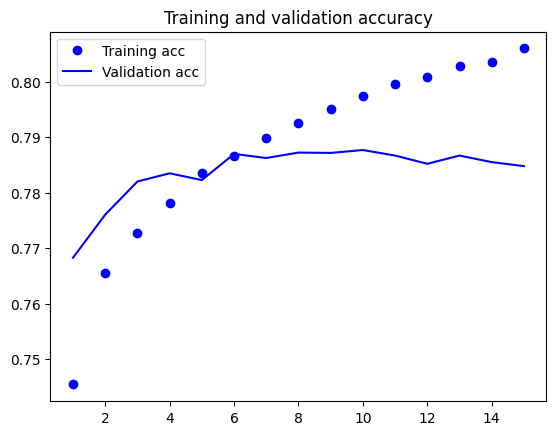

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

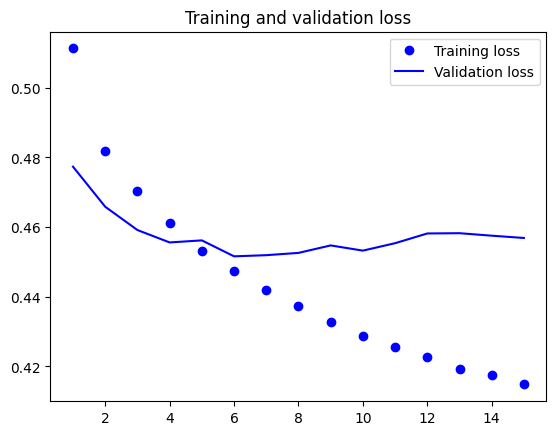

In [ ]:
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
def plot_loss_accuracy(history, fig_title):
  """
  Plots two graphs to display the accuracy and loss of a given CNN model
  """
  loss_accuracy, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
  epoch_ticks = np.arange(0, len(history.history['accuracy']), 1)
  epoch_labels = list()
  for label in range(len(epoch_ticks)):
    epoch_labels.append(str(label+1))

  plt.sca(ax1)
  ax1.plot(history.history['loss'],color='#000000',label='Training Loss',
           linewidth=3)
  ax1.plot(history.history['val_loss'],color='#000000',label='Validation Loss',
           linewidth=3, linestyle='dotted')
  ax1.set_xlabel("")
  ax1.set_ylabel("Loss")
  plt.xticks(epoch_ticks, labels=epoch_labels)
  ax1.legend()
  ax1.set_title(fig_title, y=1.1, fontsize=16)

  plt.sca(ax2)
  ax2.plot(history.history['accuracy'],color='#000000',label='Training accuracy',
           linewidth=3)
  ax2.plot(history.history['val_accuracy'],color='#000000',
           label='Validation accuracy', linewidth=3, linestyle='dotted')
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.xticks(epoch_ticks, labels=epoch_labels)
  ax2.legend()
  plt.show()

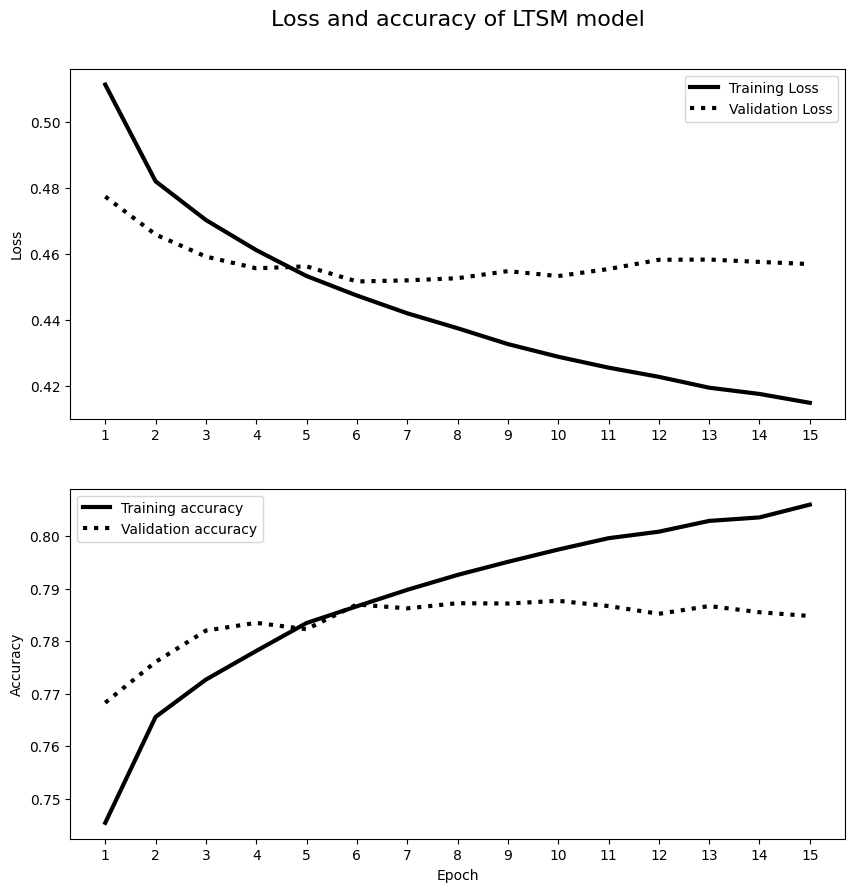

In [ ]:
plot_loss_accuracy(history, 'Loss and accuracy of LTSM model')

In [ ]:
# Load traine LTSM model
ltsm_model = load_model('/content/gdrive/My Drive/ltsm_model.keras', compile = True)

In [ ]:
y_pred = ltsm_model.predict(X_test)

1563/1563 [==============================] - 6s 3ms/step


In [ ]:
# Convert probability prediction from sigmoid function to binary prediction
for i, pred in enumerate(y_pred):
  y_pred[i] = 0 if pred[0] < 0.5 else 1

In [ ]:
# Create new dataframe containing tweet content, correct sentiment polarity, and sentiment polarity predicted by LTSM
data = {'Actual polarity': y_test.ravel(),
        'Content': X_test,
        'Predicted polarity': y_pred.ravel(),
        }


results = pd.DataFrame(data)
results = results.dropna()

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Calculate performance metrics for LTSM

def calculate_metrics(test, pred):

  accuracy = accuracy_score(test, pred)
  recall = recall_score(test, pred, average='macro')
  precision = precision_score(test, pred, average='macro')
  f1 = f1_score(test, pred, average='macro')

  return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = calculate_metrics(results["Actual polarity"], results["Predicted polarity"])

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1:", f1)

Accuracy: 0.78046
Recall: 0.7804590085778547
Precision: 0.7804590556951798
F1: 0.7804590318243303


In [ ]:
# Create new dataframe contain performance metrics
comparison_metrics = pd.DataFrame({'Accuracy':[accuracy],
                                  'Recall':[recall],
                                  'Precision':[precision],
                                  'F1':[f1]},
                                   index=['LSTM']
                                  )

path = '/content/drive/My Drive/comparison_metrics.csv'

with open(path, 'a', encoding = 'utf-8') as f:
  comparison_metrics.to_csv(f, header=True)

# Predict scraped tweets

In [ ]:
from keras.models import load_model

# Load previously trained LTSM model
ltsm_model = load_model('/content/gdrive/My Drive/ltsm_model', compile = True)

OSError: ignored

In [ ]:
path = '/content/drive/My Drive/preprocessedScraped.csv'

# Load dataset of scraped tweets
with open(path, 'r', encoding = 'utf-8') as f:
  tweets_df = pd.read_csv(f, index_col=0)

tweets_df.head(len(tweets_df))

,mdy,date,content,likes,retweets
0,2023-03-06,2023-03-06 23:58:49+00:00,girl explain bitcoin,501,140
1,2023-03-06,2023-03-06 23:58:07+00:00,roughly hour leave pulsechain testnet fully sy...,32,1
2,2023-03-06,2023-03-06 23:57:47+00:00,come join conversation bitcoin fix hood americ...,24,1
3,2023-03-06,2023-03-06 23:54:57+00:00,get haircut pay bitcoin feel good always offer...,14,0
4,2023-03-06,2023-03-06 23:54:52+00:00,bitcoin usd weekly wrong bearish rising wedge ...,721,65
...,...,...,...,...,...
354888,2022-03-07,2022-03-07 07:25:09+00:00,gold act exactly store value preserve wealth c...,264,28
354889,2022-03-07,2022-03-07 07:24:10+00:00,see selloff tym bitcoin hold ema wts go happen...,27,1
354890,2022-03-07,2022-03-07 07:23:30+00:00,many follower bitcoin bitcoin,30,16
354891,2022-03-07,2022-03-07 07:17:32+00:00,reserve risk useful opinion underused indicato...,112,22


In [ ]:
# Pad text content of dataset
X_test = pad_sequences(tokeniser.texts_to_sequences(tweets_df['content']),maxlen = max_len)

In [ ]:
# Predict sentiment polarity of tweets
y_pred = ltsm_model.predict(X_test)

11091/11091 [==============================] - 28s 3ms/step


In [ ]:
# Convert probability prediction from sigmoid function to binary prediction
for i, pred in enumerate(y_pred):
  y_pred[i] = 0 if pred[0] < 0.5 else 1

In [ ]:
# Flatten sentiment polarity prediction dataset
tweets_df['Sentiment'] = y_pred.reshape(-1)

In [ ]:
tweets_df.head(len(tweets_df))

,mdy,date,content,likes,retweets,Sentiment
0,2023-03-06,2023-03-06 23:58:49+00:00,girl explain bitcoin,501,140,1.0
1,2023-03-06,2023-03-06 23:58:07+00:00,roughly hour leave pulsechain testnet fully sy...,32,1,1.0
2,2023-03-06,2023-03-06 23:57:47+00:00,come join conversation bitcoin fix hood americ...,24,1,1.0
3,2023-03-06,2023-03-06 23:54:57+00:00,get haircut pay bitcoin feel good always offer...,14,0,1.0
4,2023-03-06,2023-03-06 23:54:52+00:00,bitcoin usd weekly wrong bearish rising wedge ...,721,65,0.0
...,...,...,...,...,...,...
354888,2022-03-07,2022-03-07 07:25:09+00:00,gold act exactly store value preserve wealth c...,264,28,0.0
354889,2022-03-07,2022-03-07 07:24:10+00:00,see selloff tym bitcoin hold ema wts go happen...,27,1,0.0
354890,2022-03-07,2022-03-07 07:23:30+00:00,many follower bitcoin bitcoin,30,16,0.0
354891,2022-03-07,2022-03-07 07:17:32+00:00,reserve risk useful opinion underused indicato...,112,22,1.0


In [ ]:
# Save dataset of tweets labeled with their sentiment polarity
path = '/content/drive/My Drive/btcTweetWithSentiment.csv'

with open(path, 'w', encoding = 'utf-8') as f:
  tweets_df.to_csv(f)